In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# Raw Data Loading

df = pd.read_csv('./data/class_csv/train_0429_color_80.csv')
display(df.head())
print(df.shape)   # (25000, 6401)

,label,0,1,2,3,4,5,6,7,8,...,19190,19191,19192,19193,19194,19195,19196,19197,19198,19199
0,21,23,16,16,59,54,65,34,25,20,...,69,47,44,51,97,93,97,31,26,30
1,61,123,125,-124,96,92,92,113,118,114,...,81,97,108,101,88,92,95,115,126,121
2,63,-107,-85,-94,124,-119,-114,123,-120,-124,...,-128,123,126,124,103,113,114,-89,-83,-86
3,9,-89,-120,96,120,98,76,117,93,71,...,60,120,96,71,104,87,68,104,83,65
4,40,54,65,96,59,70,104,61,73,110,...,98,54,67,104,65,79,116,56,65,98


(4277, 19201)


In [3]:
x_data = df.drop('label', axis=1, inplace=False).values
t_data = df['label'].values

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


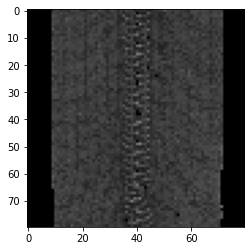

In [4]:
plt.imshow(x_data[152:153].reshape(80,80,3))
plt.show()

In [5]:
# data split
train_x_data, test_x_data, train_t_data, test_t_data = \
train_test_split(x_data,
                 t_data,
                 test_size=0.3,
                 stratify=t_data)

# Normalization(정규화)
scaler = MinMaxScaler()
scaler.fit(train_x_data)
norm_train_x_data = scaler.transform(train_x_data)
norm_test_x_data = scaler.transform(test_x_data)

# t-data one-hot encoding
# t_data에 대한 one-hot encoding 처리는 하지 않아도 돼요 (keras 설정을 이용)


In [23]:
train_x_data

array([[  30,   22,   22, ...,   27,   22,   25],
       [  31,   26,   27, ...,   27,   25,   25],
       [  47,   56,   82, ...,   47,   55,   86],
       ...,
       [ 125,  102,   76, ..., -114,  114,   78],
       [ -67,  -67,  -67, ...,  -65,  -65,  -65],
       [  77,   61,   52, ..., -107,  121,   86]])

In [6]:
# model 생성

model = Sequential()

# CNN - Feature Extraction

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 activation='relu',
                 padding='SAME',
                 input_shape=(80,80,3)))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,
                 kernel_size=(3,3),
                 activation='relu',
                 padding='SAME'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 activation='relu',
                 padding='SAME'))

model.add(MaxPooling2D(pool_size=(2,2)))

# FC Layer
model.add(Flatten())
model.add(Dropout(rate=0.5))

# Hidden layer
model.add(Dense(units=256,
                activation='relu'))

# output layer
model.add(Dense(units=88,
                activation='softmax'))

print(model.summary())

2022-05-02 10:07:52.825050: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-02 10:07:52.826150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-02 10:07:52.901814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 10:07:52.902423: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-05-02 10:07:52.902456: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-02 10:07:52.969433: I tensorflow/stream_executor/platform/default/dso_loade

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0

In [7]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# # early stopping
# es = EarlyStopping(monitor='val_loss',   # monitoring 할 값
#                    min_delta=0.01,       # threshold
#                    patience=5,           # 참는횟수
#                    mode='auto',
#                    restore_best_weights=True) # 학습한것 중에 가장 좋은것을 기억     

history = model.fit(norm_train_x_data.reshape(-1,80,80,3),
                    train_t_data.reshape(-1,1),
                    epochs=200,
                    batch_size=100,
                    verbose=1,
                    validation_split=0.3,)
#                     callbacks=[es])

model.save('./data/models/md_csv_80c_cnn_model.h5')

2022-05-02 10:20:44.196700: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-02 10:20:44.221763: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/200


2022-05-02 10:20:44.661515: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-02 10:20:45.178391: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


21/21 [==============================] - 5s 79ms/step - loss: 4.1355 - accuracy: 0.0786 - val_loss: 3.1709 - val_accuracy: 0.2105
Epoch 2/200
21/21 [==============================] - 1s 37ms/step - loss: 3.0986 - accuracy: 0.2796 - val_loss: 2.3864 - val_accuracy: 0.5111
Epoch 3/200
21/21 [==============================] - 1s 38ms/step - loss: 2.3309 - accuracy: 0.5727 - val_loss: 1.5965 - val_accuracy: 0.8129
Epoch 4/200
21/21 [==============================] - 1s 37ms/step - loss: 1.6856 - accuracy: 0.7314 - val_loss: 1.3288 - val_accuracy: 0.7751
Epoch 5/200
21/21 [==============================] - 1s 37ms/step - loss: 1.4824 - accuracy: 0.7670 - val_loss: 1.1515 - val_accuracy: 0.8185
Epoch 6/200
21/21 [==============================] - 1s 37ms/step - loss: 1.1967 - accuracy: 0.8040 - val_loss: 1.0899 - val_accuracy: 0.7996
Epoch 7/200
21/21 [==============================] - 1s 38ms/step - loss: 1.2614 - accuracy: 0.7771 - val_loss: 1.0301 - val_accuracy: 0.8396
Epoch 8/200
21/21 

21/21 [==============================] - 1s 38ms/step - loss: 0.3984 - accuracy: 0.8893 - val_loss: 0.6332 - val_accuracy: 0.8664
Epoch 59/200
21/21 [==============================] - 1s 38ms/step - loss: 0.4097 - accuracy: 0.8815 - val_loss: 0.6554 - val_accuracy: 0.8619
Epoch 60/200
21/21 [==============================] - 1s 37ms/step - loss: 0.4191 - accuracy: 0.8737 - val_loss: 0.6310 - val_accuracy: 0.8675
Epoch 61/200
21/21 [==============================] - 1s 38ms/step - loss: 0.4013 - accuracy: 0.8851 - val_loss: 0.6411 - val_accuracy: 0.8641
Epoch 62/200
21/21 [==============================] - 1s 38ms/step - loss: 0.3986 - accuracy: 0.8848 - val_loss: 0.6463 - val_accuracy: 0.8675
Epoch 63/200
21/21 [==============================] - 1s 37ms/step - loss: 0.3912 - accuracy: 0.8909 - val_loss: 0.6509 - val_accuracy: 0.8608
Epoch 64/200
21/21 [==============================] - 1s 37ms/step - loss: 0.3767 - accuracy: 0.8913 - val_loss: 0.6320 - val_accuracy: 0.8686
Epoch 65/200

21/21 [==============================] - 1s 38ms/step - loss: 0.2155 - accuracy: 0.9342 - val_loss: 0.7511 - val_accuracy: 0.8653
Epoch 116/200
21/21 [==============================] - 1s 38ms/step - loss: 0.1994 - accuracy: 0.9334 - val_loss: 0.7830 - val_accuracy: 0.8641
Epoch 117/200
21/21 [==============================] - 1s 38ms/step - loss: 0.2234 - accuracy: 0.9242 - val_loss: 0.7792 - val_accuracy: 0.8608
Epoch 118/200
21/21 [==============================] - 1s 38ms/step - loss: 0.2151 - accuracy: 0.9371 - val_loss: 0.7597 - val_accuracy: 0.8664
Epoch 119/200
21/21 [==============================] - 1s 38ms/step - loss: 0.2170 - accuracy: 0.9307 - val_loss: 0.7719 - val_accuracy: 0.8608
Epoch 120/200
21/21 [==============================] - 1s 38ms/step - loss: 0.1944 - accuracy: 0.9380 - val_loss: 0.7549 - val_accuracy: 0.8653
Epoch 121/200
21/21 [==============================] - 1s 38ms/step - loss: 0.1814 - accuracy: 0.9391 - val_loss: 0.8013 - val_accuracy: 0.8653
Epoch 

Epoch 172/200
21/21 [==============================] - 1s 38ms/step - loss: 0.0913 - accuracy: 0.9724 - val_loss: 0.9181 - val_accuracy: 0.8630
Epoch 173/200
21/21 [==============================] - 1s 38ms/step - loss: 0.1015 - accuracy: 0.9661 - val_loss: 0.9110 - val_accuracy: 0.8586
Epoch 174/200
21/21 [==============================] - 1s 38ms/step - loss: 0.0975 - accuracy: 0.9703 - val_loss: 0.9810 - val_accuracy: 0.8653
Epoch 175/200
21/21 [==============================] - 1s 38ms/step - loss: 0.1085 - accuracy: 0.9628 - val_loss: 0.9562 - val_accuracy: 0.8541
Epoch 176/200
21/21 [==============================] - 1s 38ms/step - loss: 0.0990 - accuracy: 0.9672 - val_loss: 0.9549 - val_accuracy: 0.8563
Epoch 177/200
21/21 [==============================] - 1s 38ms/step - loss: 0.1006 - accuracy: 0.9687 - val_loss: 0.9550 - val_accuracy: 0.8608
Epoch 178/200
21/21 [==============================] - 1s 38ms/step - loss: 0.1015 - accuracy: 0.9708 - val_loss: 0.9762 - val_accuracy:

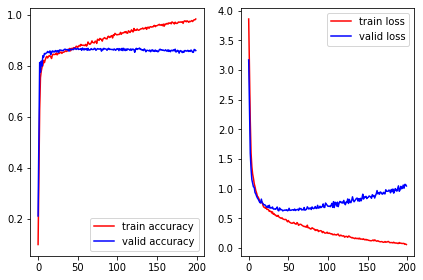

In [8]:
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure()
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train accuracy')
ax1.plot(valid_acc, color='b', label='valid accuracy')
ax1.legend()

ax2.plot(train_loss, color='r', label='train loss')
ax2.plot(valid_loss, color='b', label='valid loss')
ax2.legend()

plt.tight_layout()
plt.show()


In [9]:
result = model.evaluate(norm_test_x_data.reshape(-1,80,80,3),
                        test_t_data.reshape(-1,1))
print(result)
#        loss                accuracy
# [0.8666917681694031, 0.7685333490371704]

41/41 [==============================] - 0s 5ms/step - loss: 1.0130 - accuracy: 0.8505
[1.0129585266113281, 0.8504672646522522]


In [19]:
model.compile(optimizer=Adam(learning_rate=1e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# early stopping
es = EarlyStopping(monitor='val_loss',   # monitoring 할 값
                   min_delta=0.01,       # threshold
                   patience=5,           # 참는횟수
                   mode='auto',
                   restore_best_weights=True) # 학습한것 중에 가장 좋은것을 기억     

history = model.fit(norm_train_x_data.reshape(-1,80,80,3),
                    train_t_data.reshape(-1,1),
                    epochs=200,
                    batch_size=100,
                    verbose=1,
                    validation_split=0.3,
                    callbacks=[es])

model.save('./data/models/md_csv_80c_cnn_model.h5')

Epoch 1/200
21/21 [==============================] - 1s 49ms/step - loss: 0.0584 - accuracy: 0.9825 - val_loss: 1.0366 - val_accuracy: 0.8619
Epoch 2/200
21/21 [==============================] - 1s 37ms/step - loss: 0.0599 - accuracy: 0.9798 - val_loss: 1.0389 - val_accuracy: 0.8608
Epoch 3/200
21/21 [==============================] - 1s 37ms/step - loss: 0.0580 - accuracy: 0.9804 - val_loss: 1.0362 - val_accuracy: 0.8608
Epoch 4/200
21/21 [==============================] - 1s 38ms/step - loss: 0.0629 - accuracy: 0.9811 - val_loss: 1.0382 - val_accuracy: 0.8619
Epoch 5/200
21/21 [==============================] - 1s 37ms/step - loss: 0.0634 - accuracy: 0.9747 - val_loss: 1.0379 - val_accuracy: 0.8608
Epoch 6/200
21/21 [==============================] - 1s 37ms/step - loss: 0.0497 - accuracy: 0.9833 - val_loss: 1.0376 - val_accuracy: 0.8619


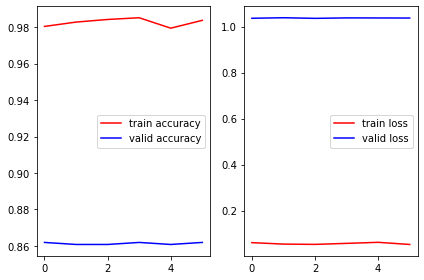

In [20]:
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

figure = plt.figure()
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.plot(train_acc, color='r', label='train accuracy')
ax1.plot(valid_acc, color='b', label='valid accuracy')
ax1.legend()

ax2.plot(train_loss, color='r', label='train loss')
ax2.plot(valid_loss, color='b', label='valid loss')
ax2.legend()

plt.tight_layout()
plt.show()


In [21]:
result = model.evaluate(norm_test_x_data.reshape(-1,80,80,3),
                        test_t_data.reshape(-1,1))
print(result)
#        loss                accuracy
# [0.8666917681694031, 0.7685333490371704]

41/41 [==============================] - 0s 4ms/step - loss: 1.0027 - accuracy: 0.8520
[1.0027300119400024, 0.8520249128341675]


## test predict

In [48]:
pred_df = pd.read_csv('./data/class_csv/test_0429_color_80.csv')
submission_df = pd.read_csv('./data/sample_submission.csv', index_col='index')

In [49]:
submission_df

,label
index,
0,tile-good
1,tile-good
2,tile-good
3,tile-good
4,tile-good
...,...
2149,tile-good
2150,tile-good
2151,tile-good


In [28]:
pred_arr = pred_df.to_numpy()
pred_arr

array([[  0,   0,   0, ...,   0,   0,   0],
       [-29, -20, -20, ..., -33, -32, -33],
       [-47, -47, -47, ..., -60, -60, -60],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [ 32,  16,  15, ...,  26,  15,  13],
       [  0,   0,   0, ..., -48, -48, -48]])

In [29]:
norm_pred_x_data = scaler.transform(pred_arr)
pred = model.predict(norm_pred_x_data.reshape(-1,80,80,3))

In [37]:
np.argmax(pred[1])

15

In [39]:
len(pred)

2154

In [56]:
file_list = ['bottle-broken_large', 'bottle-broken_small', 'bottle-contamination', 'bottle-good',
 'cable-bent_wire', 'cable-cable_swap', 'cable-combined', 'cable-cut_inner_insulation',
 'cable-cut_outer_insulation', 'cable-good', 'cable-missing_cable', 'cable-missing_wire', 'cable-poke_insulation', 'capsule-crack',
 'capsule-faulty_imprint', 'capsule-good', 'capsule-poke', 'capsule-scratch',
 'capsule-squeeze', 'carpet-color', 'carpet-cut', 'carpet-good', 'carpet-hole',
 'carpet-metal_contamination', 'carpet-thread', 'grid-bent', 'grid-broken',
 'grid-glue', 'grid-good', 'grid-metal_contamination', 'grid-thread', 'hazelnut-crack',
 'hazelnut-cut', 'hazelnut-good', 'hazelnut-hole', 'hazelnut-print', 'leather-color',
 'leather-cut', 'leather-fold', 'leather-glue', 'leather-good', 'leather-poke',
 'metal_nut-bent', 'metal_nut-color', 'metal_nut-flip', 'metal_nut-good', 'metal_nut-scratch',
 'pill-color', 'pill-combined', 'pill-contamination', 'pill-crack', 'pill-faulty_imprint', 'pill-good',
 'pill-pill_type', 'pill-scratch', 'screw-good', 'screw-manipulated_front', 'screw-scratch_head',
 'screw-scratch_neck', 'screw-thread_side', 'screw-thread_top', 'tile-crack', 'tile-glue_strip',
 'tile-good', 'tile-gray_stroke', 'tile-oil', 'tile-rough', 'toothbrush-defective', 'toothbrush-good',
 'transistor-bent_lead', 'transistor-cut_lead', 'transistor-damaged_case', 'transistor-good',
 'transistor-misplaced', 'wood-color', 'wood-combined', 'wood-good', 'wood-hole', 'wood-liquid', 'wood-scratch', 'zipper-broken_teeth',
 'zipper-combined', 'zipper-fabric_border', 'zipper-fabric_interior', 'zipper-good',
 'zipper-rough', 'zipper-split_teeth', 'zipper-squeezed_teeth']
print(len(file_list))
file_dict = { n: f_name for n, f_name in enumerate(file_list)}

88


In [57]:
file_dict[0]

'bottle-broken_large'

In [65]:
for n, row in submission_df.iterrows():
    row['label'] = file_dict[np.argmax(pred[n])]

In [66]:
submission_df

,label
index,
0,tile-good
1,capsule-good
2,screw-good
3,transistor-good
4,zipper-fabric_border
...,...
2149,zipper-good
2150,toothbrush-good
2151,leather-color


In [68]:
submission_df.to_csv('./data/0502_csv_first_submission.csv')